In [1]:
import sys, os, json, time
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

sns.set()

In [2]:
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [3]:
# transformer for data augmentation
train_transformer = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(
    root=".",
    train=True,
    transform=train_transformer,
    download=True
)

test_dataset = datasets.CIFAR10(
    root=".",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [4]:
# explore the datasets a little
train_dataset_shape = train_dataset.data.shape
print(f"[INFO] train_dataset_shape: {train_dataset_shape}......")

test_dataset_shape = test_dataset.data.shape
print(f"[INFO] test_dataset_shape: {test_dataset_shape}......")

[INFO] train_dataset_shape: (50000, 32, 32, 3)......
[INFO] test_dataset_shape: (10000, 32, 32, 3)......


In [5]:
# evaluate the unique no of classes
num_classes = len(set(train_dataset.targets))
print(f"[INFO] there are total {num_classes} unique classes......")

[INFO] there are total 10 unique classes......


In [6]:
# now create the dataloaders
batch_size = 128
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [7]:
# define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # define conv layers
        self.conv1 = nn.Sequential(
            # padding p = 1 so that output same size. basically "same" padding
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # output should now be 16 x 16 x 32
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # output should now be 8 x 8 x 64
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # output should now be 4 x 4 x 128
            nn.MaxPool2d(2)
        )

        # output of last conv is 3 x 3 activation map
        # define linear layers
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # different - we are using Functional module
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)

        return x

In [8]:
# set device and instantiate model
model = CNN(num_classes=num_classes)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"[INFO] available device: {device}......")

# move model to device
model.to(device=device)

[INFO] available device: cuda:0......


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [9]:
# set the criterions and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [10]:
# function to train the model
def batch_gd(model: nn.Module,
             criterion: nn.CrossEntropyLoss,
             optimizer: optim.Adam,
             train_loader: DataLoader,
             test_loader: DataLoader,
             epochs: int):
    # initalise the loss arrays
    epoch_train_losses = np.zeros(epochs)
    epoch_test_losses = np.zeros(epochs)

    # start the training loop
    for epoch in range(epochs):
        # set mode to model train to turn on dropout, batchnorm
        model.train()
        start_epoch = time.time()
        batch_train_losses = []
        batch_test_losses = []

        for inputs, targets in train_loader:
            # move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the optimizer
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # backward step and optimize
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())

        # now start the eval loop
        for inputs, targets in test_loader:
            model.eval()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_test_losses.append(loss.item())

        # after everything is done
        end_epoch = time.time()
        epoch_train_loss = np.mean(batch_train_losses)
        epoch_test_loss = np.mean(batch_test_losses)
        epoch_train_losses[epoch] = epoch_train_loss
        epoch_test_losses[epoch] = epoch_test_loss

        print(f"[INFO] epoch: {epoch + 1} with train_loss: {epoch_train_loss: 0.3f} and test_loss: {epoch_test_loss: 0.3f} took {end_epoch - start_epoch: 0.3f} seconds......")

    return epoch_train_losses, epoch_test_losses

In [11]:
# train the model
train_losses, test_losses = batch_gd(model=model,
         criterion=criterion,
         optimizer=optimizer,
         train_loader=train_loader,
         test_loader=test_loader,
         epochs=80)

[INFO] epoch: 1 with train_loss:  1.430 and test_loss:  1.058 took  22.738 seconds......
[INFO] epoch: 2 with train_loss:  1.021 and test_loss:  0.918 took  21.820 seconds......
[INFO] epoch: 3 with train_loss:  0.850 and test_loss:  0.802 took  21.490 seconds......
[INFO] epoch: 4 with train_loss:  0.756 and test_loss:  0.711 took  21.676 seconds......
[INFO] epoch: 5 with train_loss:  0.687 and test_loss:  0.748 took  21.365 seconds......
[INFO] epoch: 6 with train_loss:  0.640 and test_loss:  0.622 took  21.439 seconds......
[INFO] epoch: 7 with train_loss:  0.604 and test_loss:  0.670 took  21.705 seconds......
[INFO] epoch: 8 with train_loss:  0.573 and test_loss:  0.615 took  21.461 seconds......
[INFO] epoch: 9 with train_loss:  0.549 and test_loss:  0.588 took  21.685 seconds......
[INFO] epoch: 10 with train_loss:  0.524 and test_loss:  0.532 took  21.633 seconds......
[INFO] epoch: 11 with train_loss:  0.506 and test_loss:  0.543 took  21.546 seconds......
[INFO] epoch: 12 wi

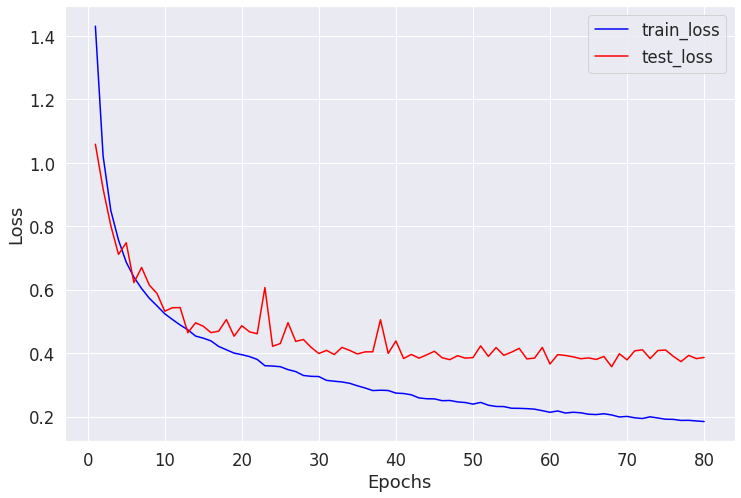

In [12]:
sns.set(font_scale=1.5)
f, ax = plt.subplots(1, 1, figsize=(12, 8))  # type: Figure, Axes
x = np.arange(80) + 1
sns.lineplot(x=x, y=train_losses, ax=ax, color="blue", label="train_loss")
sns.lineplot(x=x, y=test_losses, ax=ax, color="red", label="test_loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss");


In [13]:
# calculate model accuracies
train_corrects = 0
test_corrects = 0
train_total = 0
test_total = 0

model.eval()
with torch.no_grad():
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, indices = torch.max(outputs, dim=1)
        corrects = (targets == indices).sum().item()
        train_corrects += corrects
        total = targets.shape[0]
        train_total += total

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, indices = torch.max(outputs, dim=1)
        corrects = (targets == indices).sum().item()
        test_corrects += corrects
        total = targets.shape[0]
        test_total += total

print(f"[INFO] train_acc: {(train_corrects/train_total): 0.3f} and test_acc: {(test_corrects/test_total): 0.3f}......")

[INFO] train_acc:  0.941 and test_acc:  0.887......


In [14]:
# plot the confusion matrix
x_test = test_dataset.data
all_true_targets = np.array([])
all_predictions = np.array([])

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, indices = torch.max(outputs, dim=1)
        all_true_targets = np.concatenate((all_true_targets, targets.cpu().numpy()))
        all_predictions = np.concatenate((all_predictions, indices.cpu().numpy()))

In [15]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix


def print_confusion_matrix(confusion_matrix, class_names, figsize=(10, 7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

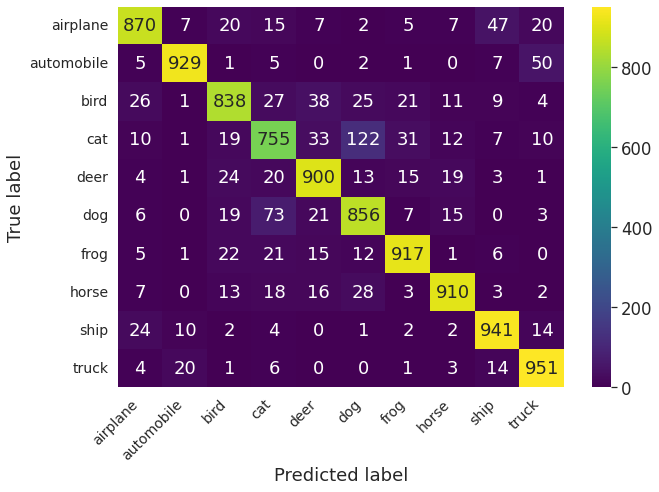

In [16]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']
id_to_names = {i:name for i, name in enumerate(labels)}
cm = confusion_matrix(all_true_targets, all_predictions)
print_confusion_matrix(cm, class_names=labels)

[INFO] true_label: dog and predicted_label: bird......


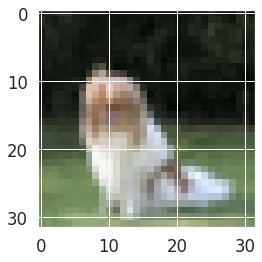

In [19]:
# indices where preds dont match targets
no_match_indices= np.where(all_true_targets != all_predictions)[0]

# look at misclassified images
random_id = np.random.choice(no_match_indices)

# choose a rnadom image from test set
x_random = x_test[random_id]

# plt the randomly chosen image
plt.imshow(x_random)

# get the true target label
true_label = id_to_names[all_true_targets[random_id]]
predicted_label = id_to_names[all_predictions[random_id]]
print(f"[INFO] true_label: {true_label} and predicted_label: {predicted_label}......")